In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from constants import *

from ddpg_multi_agent import MultiAgent

Loading new constants


In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [6]:
multi_agent = MultiAgent(state_size=state_size, action_size=action_size, num_agents=num_agents,random_seed=0)

/home/workspace/ddpg_network.py:81: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(param)
/home/workspace/ddpg_network.py:79: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.0)
/home/workspace/ddpg_network.py:169: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(param)
/home/workspace/ddpg_network.py:167: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(param, 0.0)


In [7]:
def ddpg_ma():
    scores_window = deque(maxlen=100)
    agent_scores = []
    scores_moving_avg = []
    max_score = -100
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations       
        multi_agent.reset()
        scores = np.zeros(num_agents)      
        for t in range(max_t):
            actions = multi_agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done 
            multi_agent.step(states, actions, rewards, next_states, dones)    
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
            
        agent_scores.append(np.mean(scores)) 
        scores_window.append(agent_scores[-1]) 
        scores_moving_avg.append(np.mean(scores_window))
        if (np.max(scores) > max_score):
            max_score = np.max(scores)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tAgent 1 Score: {:.2f}\tAgent 2 Score: {:.2f}'.format(i_episode, scores_moving_avg[-1], agent_scores[-1], scores[0],scores[1]), end="")
        if i_episode % 100 == 0:
            #print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_episode, scores_moving_avg[-1]))
            print('\n')
            max_score = -100
        if scores_moving_avg[-1] >= TARGET_SCORE:
            file_suffix = 'checkpoint-%s-%i.pth'
            for agent_i in range(num_agents):
                actor_path = file_suffix % ('actor', agent_i)
                critic_path = file_suffix % ('critic', agent_i)
                torch.save(multi_agent.ddpg_agents[agent_i].actor_local.state_dict(), actor_path)
                torch.save(multi_agent.ddpg_agents[agent_i].critic_local.state_dict(), critic_path)
            
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, scores_moving_avg[-1]))
            break
    return agent_scores, scores_moving_avg

In [8]:
scores, scores_mean = ddpg_ma()

Episode 100	Average Score: -0.00	Score: -0.00	Agent 1 Score: 0.00	Agent 2 Score: -0.01

Episode 200	Average Score: 0.00	Score: 0.05	Agent 1 Score: 0.10	Agent 2 Score: -0.0111

Episode 300	Average Score: 0.05	Score: 0.05	Agent 1 Score: -0.01	Agent 2 Score: 0.100

Episode 400	Average Score: 0.11	Score: 0.10	Agent 1 Score: 0.10	Agent 2 Score: 0.0901

Episode 500	Average Score: 0.23	Score: 0.45	Agent 1 Score: 0.50	Agent 2 Score: 0.3910

Episode 546	Average Score: 0.51	Score: 1.25	Agent 1 Score: 1.30	Agent 2 Score: 1.1910
Environment solved in 446 episodes!	Average Score: 0.51


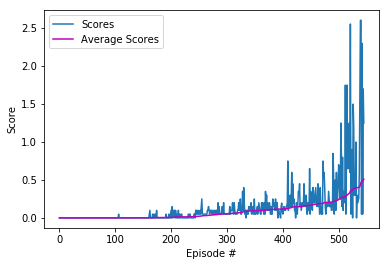

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores)), scores_mean, c='m', label='Average Scores')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [12]:
multi_agent = MultiAgent(state_size=state_size, action_size=action_size, num_agents=num_agents,random_seed=0, load_file='checkpoint-%s-%i.pth')

for episode in range(2):
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations       
    score = np.zeros(num_agents)               
    while True:
        actions = multi_agent.act(states, add_noise=False)                       
        env_info = env.step(actions)[brain_name]        
        next_states = env_info.vector_observations     
        rewards = env_info.rewards       
        dones = env_info.local_done
        score += rewards
        states = next_states
        if np.any(dones):                              
            break
    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.mean(score)))      


UnityEnvironmentException: No Unity environment is loaded.

In [11]:
#env.close()